In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [38]:
import os, sys

import experiment_util
import evaluation_util as eva
import evaluation_util
import pandas as pd

from heapq import nsmallest
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import experiment_util as ex2util
from experiment_util import hyper_init_dict
import experiment_models as ex2models

import theano_models as tm
import theano_models.probabilistic_models as pm
from theano.tensor.shared_randomstreams import RandomStreams
from schlichtanders.myobjects import NestedNamespace
from schlichtanders.mydicts import update

import numpy as np

In [39]:
pm.RNG = NestedNamespace(tm.PooledRandomStreams(pool_size=int(1e8)), RandomStreams())

In [40]:
main_folder = os.path.dirname(os.getcwd())

sys.path.append(main_folder)

import experiment1.experiment_util as ex1util
Hypers = ex1util.get_hyper(), ex1util.get_semiold_hyper(), ex1util.get_old_hyper()

# global

In [41]:
Hyper = ex2util.get_hyper()
filepath = os.path.realpath("interactive.db")

In [42]:
datasetnames = ["boston","concrete","energy","powerplant","kin8nm", "winered","yacht"] #, "toy1d","toy2d"]
folders = ["../experiment1/withpercent", '../experiment1/first_useful_hyperparameter_search', '../experiment1/run_windows/']

In [43]:
datasetname = datasetnames[2]
modelname = "planarflow"
optimization_type = "annealing"
print datasetname, modelname, optimization_type

energy planarflow annealing


# get best parameters / hyper

In [44]:
reload(eva)

<module 'evaluation_util' from '/home/stephan/GitProjects/theano_models/experiment2/__file__'>

In [45]:
best_hyper = eva.get_single_best_hyper(folders, "radialflowdet", Hypers=Hypers, attr="best_val_loss", 
                                       key_files=lambda fn, p: datasetname in fn)

In [46]:
print best_hyper.best_val_loss
print best_hyper.best_val_error
print best_hyper.best_parameters
print best_hyper.n_normflows

-1.63544751122
0.429805189371
[-0.94714725  2.70755067 -1.41421348 ..., -0.07848868  0.08868879
 -0.05529198]
3


# test runs

In [47]:
data, error_func = ex2util.load_and_preprocess_data(datasetname)
X, Z, VX, VZ, TX, TZ = data

In [48]:
init_dict = {k:v for k, v in best_hyper.__dict__.iteritems() if k[:3] not in ["bas", "pla", "rad", "mix"]}
del init_dict['best_val_loss']
update(init_dict, ex2util.get_init_data(data), overwrite=True)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f4b57df27d0>,
 'batch_size': 1,
 'best_parameters': array([-0.94714725,  2.70755067, -1.41421348, ..., -0.07848868,
         0.08868879, -0.05529198]),
 'best_test_error': 0.6929286122322083,
 'best_test_loss': -1.077096517983969,
 'best_val_error': 0.429805189371109,
 'datasetname': u'energy',
 'errorrate_average_n': 10,
 'example_input': array([-1.3638159 ,  1.55394244,  1.12390304,  0.97250992, -1.        ,
        -1.34164071,  0.11736926, -1.16939282], dtype=float32),
 'example_output': array([-0.7157346], dtype=float32),
 'exp_average_n': 20,
 'exp_ratio_estimator': u'grouping',
 'id': 20,
 'init_parameters': array([ 0.70659138,  0.97621381, -0.12512178, ..., -1.73443029,
         0.40963185,  1.48943319]),
 'logP_average_n': 3,
 'max_epochs_without_improvement': 30,
 'minus_log_s1': 1,
 'minus_log_s2': 6,
 'modelname': 'radialflowdet',
 'n_layers': 1,
 'n_normflows': 3,
 'opt_decay': 0.8925774839235782,
 'opt_ident

In [49]:
hyper = Hyper(datasetname, modelname, optimization_type="annealing")  #"annealing"
hyper_init_dict(hyper, init_dict)
hyper.annealing_T = 100
hyper.adapt_prior = True
if hyper.adapt_prior:
    hyper.init_parameters = np.r_[hyper.init_parameters, 0]
hyper.max_epochs_without_improvement = 40

if "radial" in modelname:
    hyper.n_normflows = 2*hyper.n_normflows  # compatibility issue

In [50]:
hyper.init_parameters = None
hyper.n_normflows = 10

In [51]:
engine = create_engine('sqlite:///' + filepath)  # os.path.join(__path__, foldername, '%s.db' % filename)
Hyper.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
sql_session = Session()

<IPython.core.display.Javascript object>


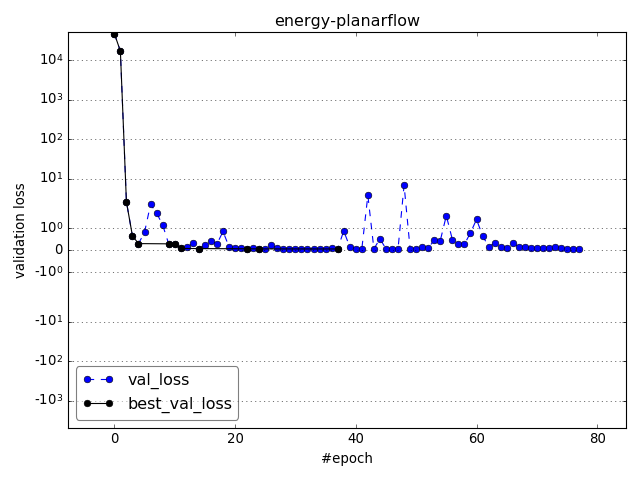

In [52]:
plt.figure()
h_val = plt.plot([],[], color='blue', linestyle='dashed', marker='o', label="val_loss")[0]
h_best_val = plt.plot([], [], color='black', linestyle='solid', marker='o', label="best_val_loss")[0]
plt.yscale('symlog')
# plt.tick_params(axis='y', which='minor')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.1g"))
# plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
plt.gca().yaxis.grid(True)
plt.ylabel("validation loss")
plt.xlabel("#epoch")
plt.title("%s-%s" % (datasetname, modelname))
plt.legend(loc='lower left', fancybox=True, framealpha=0.5)

In [53]:
model_creator = getattr(ex2models, modelname)
model, approx_posterior = model_creator(hyper)

ex2util.optimize(data, hyper, model, error_func, plot_val=h_val, plot_best_val=h_best_val)

normalizing flow annealing
new random init_parameters
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78


hyper 8747598002293

In [54]:
hyper.best_test_loss

0.50836348484849403

In [55]:
hyper.best_val_loss

0.51528120050040327

In [56]:
hyper.best_test_error

332.32859382443746

In [57]:
hyper.best_val_error

270.0629560758037